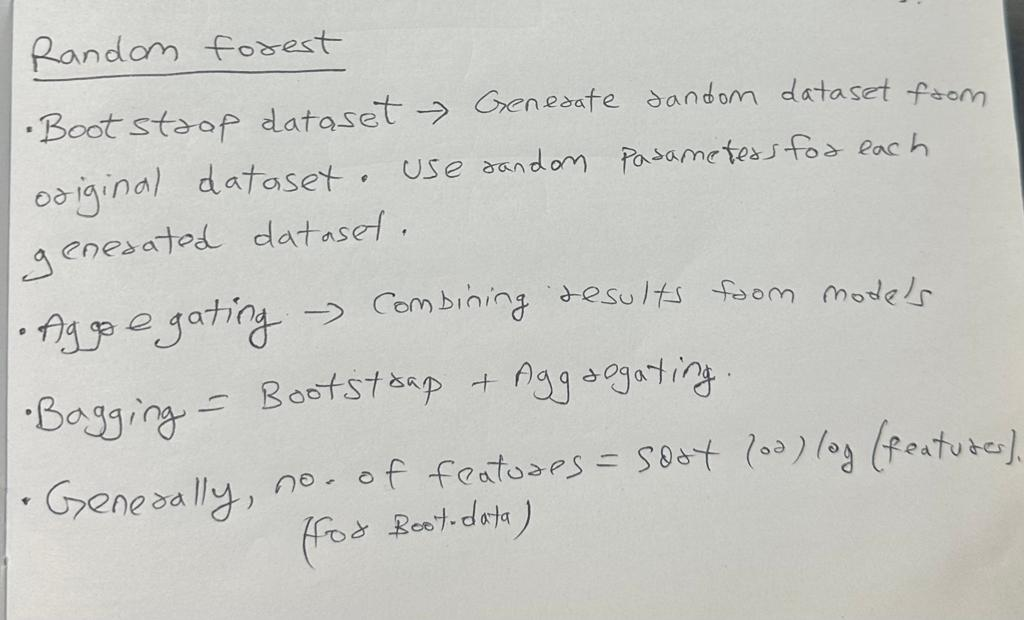

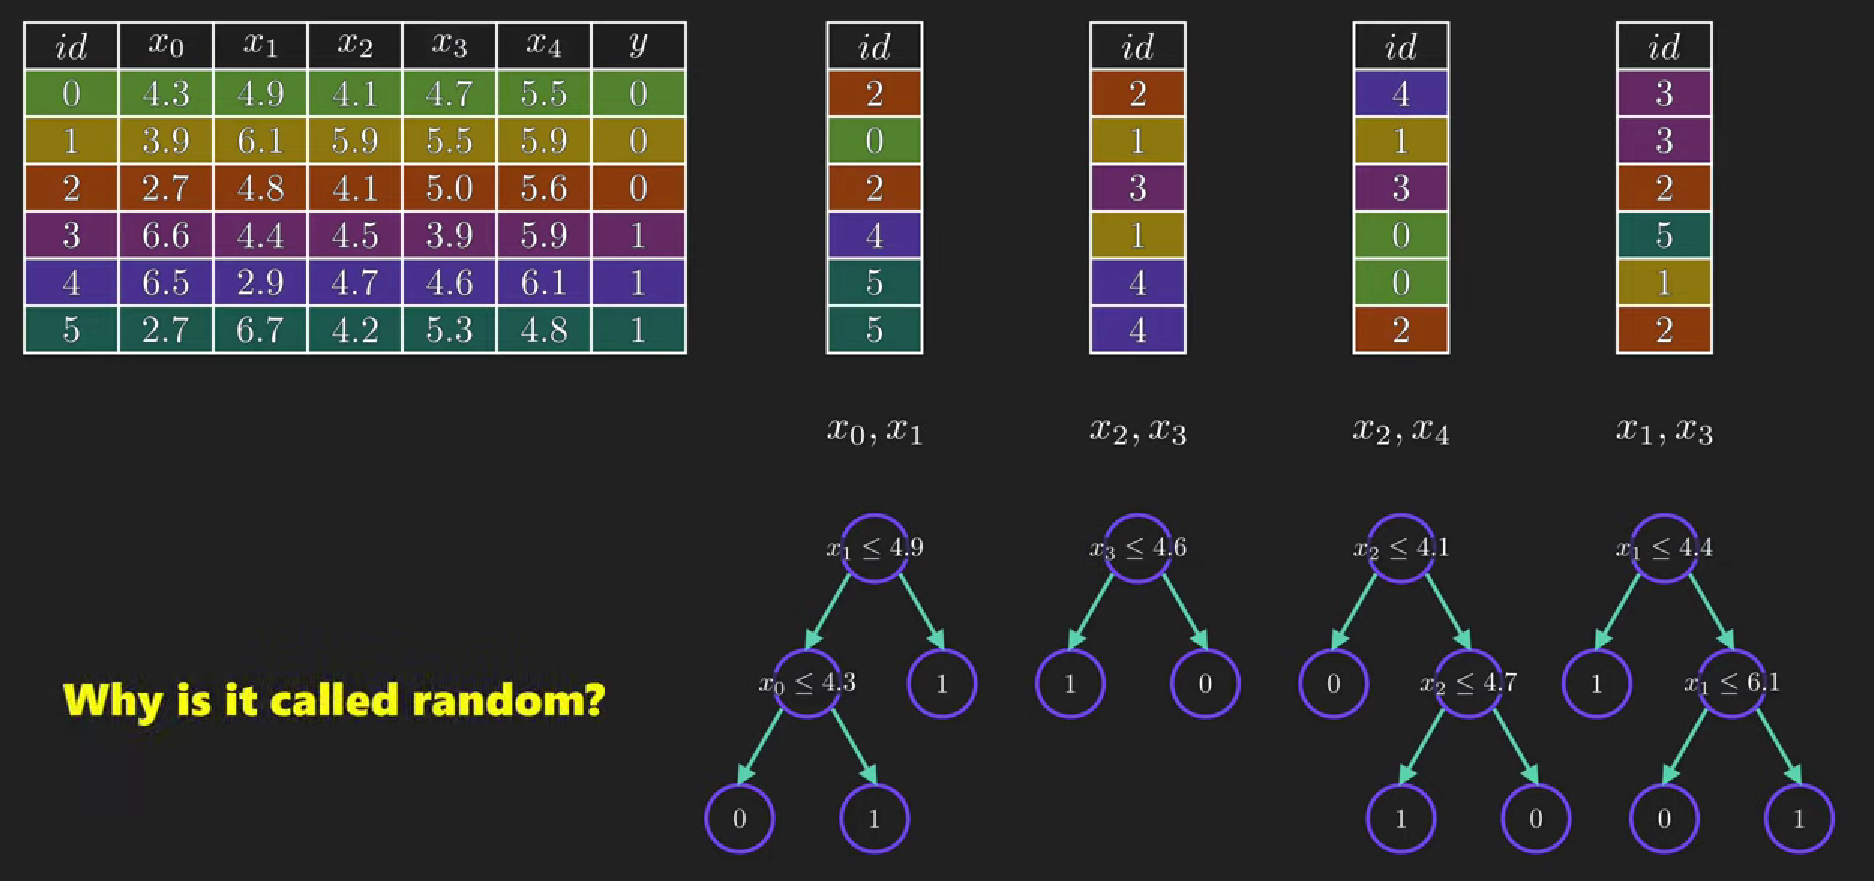

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1) From Scratch

In [10]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/machine_learning/datasets/diabetes.csv')

# Extract features (X) and target variable (y)
X = data.drop('Outcome', axis=1)
Y = data['Outcome']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

from collections import Counter
import numpy as np

def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return pd.DataFrame(X.values[idxs, :], columns=X.columns), y.iloc[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats,
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

# Create and train the Random Forest Classifier from scikit-learn
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_rf = rf_classifier.predict(X_test)

# Print true values, predicted values, and accuracy of the model
print("True Values:", Y_test.values)
print("Predicted Values (Random Forest):", Y_pred_rf)
print("Accuracy (Random Forest):", accuracy_score(Y_test, Y_pred_rf))


True Values: [0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1
 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0
 0 0 0 0 0 0]
Predicted Values (Random Forest): [0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0
 0 1 0 0 0 0]
Accuracy (Random Forest): 0.7727272727272727


2) Using *SCIKIT*

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/machine_learning/datasets/diabetes.csv')

# Extract features (X) and target variable (y)
X = data.drop('Outcome', axis=1)
Y = data['Outcome']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

# Create and train the Random Forest Classifier from scikit-learn
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_rf = rf_classifier.predict(X_test)

# Print true values, predicted values, and accuracy of the model
print("True Values:", Y_test.values)
print("Predicted Values (Random Forest):", Y_pred_rf)
print("Accuracy (Random Forest):", accuracy_score(Y_test, Y_pred_rf))


True Values: [0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1
 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1
 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0
 0 0 0 0 0 0]
Predicted Values (Random Forest): [0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0
 0 1 0 0 0 0]
Accuracy (Random Forest): 0.7727272727272727
